# 프로젝트 : 폐렴 진단기 성능개선
### 개요
pneumonia_segmentation.ipynb 파일에서 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.  
그러나 90% 이상에 도달하는 숙련된 의사분들 유사한 성능을 내기 위하여 모델 성능을 향상시켜보려 합니다.  
### 목차
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. ResNet-18 구현
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

### 회고

### 참조
---

우선 주요 라이브러리 버전을 확인해 보겠습니다.

In [49]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [50]:
# 패키지(라이브러리)들을 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [86]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# epochs을 10 -> 8로 조정
BATCH_SIZE = 16
EPOCHS = 1


print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
데이터는 아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

- train
    - NORMAL
    - PNEUMONIA
- test
    - NORMAL
    - PNEUMONIA
- val
    - NORMAL
    - PNEUMONIA

In [52]:
# train, test, validation 각 데이터들의 개수 확인하기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # TRAIN_PATH 내의 모든 파일에 대한 리스트를 반환하여 train_filenames 변수에 할당
test_filenames = tf.io.gfile.glob(TEST_PATH)   # TEST_PATH 내의 모든 파일에 대한 리스트를 반환하여 test_filenames 변수에 할당
val_filenames = tf.io.gfile.glob(VAL_PATH)   # VAL_PATH 내의 모든 파일에 대한 리스트를 반환하여 val_filenames 변수에 할당

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [53]:
train_filenames

['/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0487-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0987-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0700-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0674-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0504-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1303-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0530-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1174-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0450-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0374-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0619-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1157-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0529-0001.jpeg',
 '/aiffel/ai

- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
- 개수 비율은 89%, 10.7%, 0.3% 로 val개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져옵니다.
- train, val 데이터를 모은 후 train:val = 80:20으로 분할

In [54]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)   # 전체 데이터셋에서 80%에 해당하는 훈련 데이터의 크기를 계산. math.floor 함수를 사용하여 소수점 이하를 버림.
random.seed(8)                                # 난수 발생 시드를 8로 설정합니다. 이는 난수 생성의 초기 상태를 지정하는데 사용됨.
random.shuffle(filenames)                     # 리스트 내의 파일 경로들을 무작위로 섞기
train_filenames = filenames[:train_size]      # 섞인 리스트에서 처음부터 훈련 데이터의 크기까지를 선택하여 훈련 데이터셋으로 지정
val_filenames = filenames[train_size:]        # 나머지 부분을 검증 데이터셋으로 지정

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 80:20으로 분할 결과 train은 4185개, test는 624개, val은 1047개가 되었습니다.
- test_size를 수정하면 개수는 달라질 수 있습니다.

In [55]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기


- 정상 이미지와 폐렴 이미지의 구분은 파일 경로로 알 수 있습니다. : NORMAL, PNEUMONIA
- 즉, 정상 이미지와 폐렴 이미지의 개수는 파일 경로에 각각 NORMAL, PNEUMONIA이 있는지 확인하면 셀 수 있습니다.

In [56]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


결과 해석하기

- 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.
- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.  

tf.data 인스턴스를 만들기
- tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [57]:
# train_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 훈련 데이터셋을 만듭니다.
# val_filenames 리스트에 있는 각 파일 경로를 원소로 하는 텐서를 생성하여 검증 데이터셋을 만듭니다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [58]:
# Train 데이터셋, validation 데이터셋의 크기(이미지 개수) 확인

# TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds) # tensorflow형식의 데이터 포맷
# print(type(TRAIN_IMG_COUNT))
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
# print(type(TRAIN_IMG_COUNT))
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [59]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄입니다.  

- decode_img 함수와 process_path 함수를 만들겠습니다.
    - process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.
    - get_label을 이용해서 라벨 값을 가져옵니다.

In [60]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정. 보통 0에서 255 사이의 정수값을 0에서 1 사이의 부동소수점 값으로 조정하는 과정이다.
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.

- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [61]:
# map()함수는 데이터셋(train_list_ds, val_list_ds)의 각 요소에 함수(process_path)를 적용하여 변환하는 역할을 합니다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (180, 180, 3)
Data type:  <dtype: 'float32'>
Label:  True


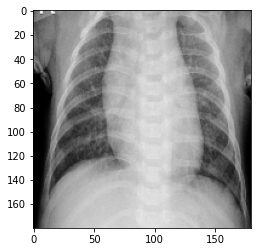

In [62]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Data type: ", image.dtype)
    print("Label: ", label.numpy())
    
plt.figure()
plt.imshow(image.numpy())
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

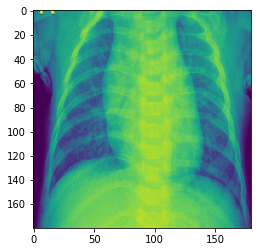

In [63]:
plt.figure()
plt.imshow(image.numpy()[:,:,2])


- train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다.
- 그리고 데이터 개수도 확인하겠습니다.

In [64]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()   # test 데이터셋의 크기(이미지 개수) 확인
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)       # 이미지 파일의 경로를 입력하여 이미지와 라벨을 읽기
test_ds = test_ds.batch(BATCH_SIZE)   # 데이터셋을 배치 단위로 묶기

print(TEST_IMAGE_COUNT)

624


의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 따라서 augmentation 기법을 활용해보고자 합니다.   
그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다.   
특히 X-RAY 같은 의료 영상의 특성 상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.

- 다음은 좌우 반전과 밝기 조정 augmentation 함수를 생성하여 도입하는 과정입니다.

In [65]:
# 좌우 반전 augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.  

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,  
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.  

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [66]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,       # augment(좌우 반전) 함수 적용
        num_parallel_calls=2 # worker
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.  
좌우 반전과 밝기 조정 augmentation이 제대로 처리되었는지를 show_batch() 함수를 통해 확인해 봅니다.

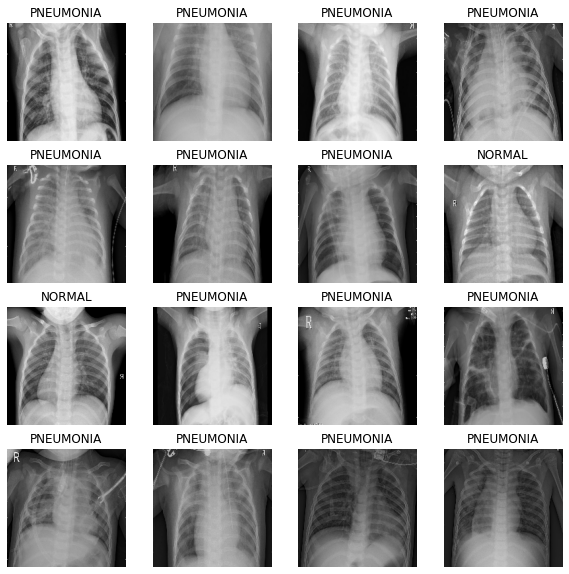

In [67]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)   # math.ceil(BATCH_SIZE/4)는 배치 크기를 4로 나눈 결과를 올림하여 필요한 행의 수를 계산
        plt.imshow(image_batch[n])   # 현재 서브플롯에 이미지를 표시
        
        # 현재 이미지에 대한 라벨이 참(True)이면 ("PNEUMONIA"), 그렇지 않으면 ("NORMAL")으로 설정
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


# 훈련 데이터셋으로부터 하나의 배치를 가져오기 - iter(train_ds)로부터 next 함수를 사용하여 다음 배치를 추출
image_batch, label_batch = next(iter(train_ds))
# show_batch 함수를 사용하여 훈련 데이터셋의 일부 이미지를 시각화
show_batch(image_batch.numpy(), label_batch.numpy())

좌우 반전
- 이미지 내의 R표시는 원본 이미지의 경우 좌측에 있습니다.  
- R표시가 우측에 있는 이미지들이 발견되므로 좌우 반전이 적용된 것을 확인할 수 있습니다.  

밝기 조정
- 밝기 조정으로 오히려 장기와 뼈, 폐 영역의 구분이 원본에 비해 모호해졌습니다.
- 성능에 좋은 영향을 미치지 못할 것으로 예상되어 prepare_for_training 함수에서 밝기 조정은 제외하고 진행하겠습니다.

In [68]:
# 이미지 Resize가 잘 되었는지, 라벨이 잘 들어가있는지 확인하기

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Data type: ", image.dtype)
    print("Label: ", label.numpy())

# train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (16, 180, 180, 3)
Data type:  <dtype: 'float32'>
Label:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True]


## Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.   
Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다.   
ResNet-18은 ResNet의 가장 작은 버전입니다.   

ResNet은 Residual block을 먼저 구성해야 합니다.   
ResNet에서의 weight layer는 아래와 같이 구성되어 있습니다.

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU  

![Residual Block](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)  

- residual block 참조 블로그 : [residual_block](https://hnsuk.tistory.com/31)

![residual_block](/aiffel/chest_xray/residual_block.png)

### Residual block 구성하기

In [69]:
# 라이브러리 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

- skip connection이 구현된 함수 residual_module을 정의

In [70]:
def residual_module(input_layer, n_filters=128, kernel_size=(3,3), strides=(1,1), padding=(1,1)):
    merge_input = input_layer
    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.

    # 1번째 CNN layer : Conv2D layer, BatchNormalization, Activation(Relu)
    x = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # 2번째 CNN layer : Conv2D layer, BatchNormalization, Activation(Relu)
    x = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)

    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = keras.layers.Add()([x, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer

**ResNet Class 전체 코드**  
이미지와 같은 Residual block을 구성한 후, 아래와 같이 ResNet을 구현합니다.   
(참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿀 예정입니다.)   
![ResNet 구현](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)

In [71]:
def ResNet18(pool_size=7):
    # Input layer 정의 및 residual module 생성
    inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # conv1
    x = keras.layers.SeparableConv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)
    
    # conv2_x의 maxpooling
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # conv2_x : Residual_block
    x = residual_module(x, 64)
    x = residual_module(x, 64)
    
    # con3_x : Residual_block
    x = residual_module(x, 128)
    x = residual_module(x, 128)
    
    # con4_x : Residual_block
    x = residual_module(x, 256)
    x = residual_module(x, 256)
    
    # con5_x : Residual_block
    x = residual_module(x, 512)
    x = residual_module(x, 512)
    
    # Average Pool Layer : 마지막 층
    x = keras.layers.AveragePooling2D(pool_size)(x)
    x = keras.layers.Dense(1000, activation='sigmoid')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    # softmax는 activation역할보다는 normalize의 성격의 띈다.
    
    model = keras.Model(inputs, outputs, name='resnet18_model')
    
    return model

# Step 5. 데이터 imbalance 처리
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었습니다.  
한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.  

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.  
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.  

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다.  
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [72]:
# 가중치 = (1/클래스의 샘플 수) x 총 샘플 수 / 2.0
# 1/2.0을 곱해주는 이유는 가중치를 상대적으로 줄이기 위함 -> 만약 이 부분이 없다면, 특히 불균형이 심한 경우에는 어떤 클래스의 샘플이 많아서 그 쪽으로 편향된 학습이 이루어질 수 있다.
weight_for_0 = (TRAIN_IMG_COUNT / COUNT_NORMAL)/2.0 
weight_for_1 = (TRAIN_IMG_COUNT / COUNT_PNEUMONIA)/2.0

# 클래스 0과 클래스 1에 대한 가중치를 딕셔너리로 저장. 이 가중치는 모델 학습 시 사용.
class_weight = {0: weight_for_0, 1: weight_for_1}



In [73]:
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


- 생각해보기  
    - 만약 imbalance 처리를 생략한다면 어떻게 될까?  
        - 학습 자체가 제대로 이뤄지지 않거나, 과적합이 될 것이라 예상된다.
    - 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까?
        - 이미 정답인 것을 맞추는 recall을 강조하는 것이 의미있는 액션일까? 하는 의문이 든다.
        - 더 강화하는 효과가 있다면 무엇일지 궁금하다.

# Step 6. 모델 훈련
- 이미지 훈련에 GPU를 사용합니다.
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다.
- 성능 향상을 위해 optimizer나 learning rate 등의 변화를 고려해볼 수 있습니다.

In [74]:
with tf.device('/GPU:0'):
    resnet_model = ResNet18()
    resnet_model.summary()

    # 평가 지표
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # 학습률 설정
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    resnet_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "resnet18_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 90, 90, 64)   403         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 45, 45, 64)   0           separable_conv2d_2[0][0]         
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 45, 45, 64)   36928       max_pooling2d_2[0][0]            
_____________________________________________________________________________________

# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅니다.   
우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.   
훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해봅니다.

- 아래 코드는 훈련된 모델을 재사용하거나 훈련을 처음부터 시작하는 데 사용  
    - 'resnet_model.keras' 파일이 존재하지 않으면, 새로운 훈련이 시작됩니다.
    - 파일이 존재하면, 이전에 저장된 모델과 이력에서 가져온 초기 에폭부터 훈련을 재개합니다.

In [120]:

initial_epoch = 0
if os.path.exists('resnet_model.keras'):
    resnet_model = keras.models.load_model("resnet_model.keras")
    print('Load pretrained ResNet18 model!')
    resnet_model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history = pickle.load(open('hist.keras', "rb"))
    initial_epoch = history['epochs']
    print(f'Resume training from {initial_epoch}')
    epochs = EPOCHS + initial_epoch
else:
    epochs = EPOCHS


Load pretrained ResNet18 model!
Resume training from 1


In [122]:
with tf.device('/GPU:0'):
    history = resnet_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        initial_epoch=initial_epoch,
    )

Epoch 2/2
261/261 [==============================] - 100s 349ms/step - loss: 0.1491 - accuracy: 0.9471 - precision: 0.9730 - recall: 0.9509 - val_loss: 3.0108 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000


In [124]:
# model save
import pickle 


hist = history.history
hist.update(history.params)
with open('hist.keras', 'wb') as fid:
    pickle.dump(hist, fid)
        
# del resnet_model
# history = pickle.load(open('hist.keras', "rb"))
print(hist)

resnet_model.save("resnet_model.keras", overwrite=True)
print('Model saved.')
del resnet_model

{'loss': [0.14907081425189972], 'accuracy': [0.94707852602005], 'precision': [0.9730443954467773], 'recall': [0.9509297609329224], 'val_loss': [3.010772705078125], 'val_accuracy': [0.7423076629638672], 'val_precision': [0.7423076629638672], 'val_recall': [1.0], 'verbose': 1, 'epochs': 2, 'steps': 261}


ValueError: Unable to create dataset (name already exists)

---

## 회고
### KEEP
- 과정(흐름) 자체는 대략적으로 이해하였다.
- 데이터 증강(좌우 반전, 밝기 조정)을 시도해보고, 적절한 것만 남겼다.
- 해결이 어려운 코드를 구글링하고 적용해보며 모델 완성을 시도하였다.

### PROBLEM
- ResNet 구현 자체가 어렵고, 어디서부터 어떻게 해야할지 아예 감이 잡히지 않았다.
- 노드학습에서 배운 방식대로 데이터 전처리를 한 이후 구글링으로 모델 코드를 참조할 때 어떻게 적용해야할지 모르겠다.

### TRY
- ResNet 구현과 구글링한 코드 적용하는 방법과 관련하여   
퍼실님, 그루분들, 친구 등에 도움을 요청하여 내 코드를 같이 보면서 수정 및 작성해보는 연습 해보기.

---

### Reference
- ResNet 
    - ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.
    - ResNet의 특징은 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. 
    ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.   
    
- ResNet18 모델 참조 블로그
    - [ResNet18 파이토치 코드리뷰](https://yhkim4504.tistory.com/3)
    - [ResNet18 코드 구현](https://haystar.tistory.com/94)
    - [폐렴 진단 베이스라인 모델과 성능 개선](https://gongboogi.tistory.com/15)
    - [ResNet 개념](https://coding-yoon.tistory.com/141)
    - [ResNet](https://www.slideshare.net/DataScienceLab/ss-249899490)
    - [구현1](https://github.com/Woodywarhol9/aiffel/blob/main/Exploration/project/%5BE11%5Dpneumonia_detection_pjt.ipynb)
    - [구현2](https://velog.io/@och9854/E-09-Pneumonia)
- [텐서플로우 데이터 증강](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)